In [1]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from tensorflow import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


Using TensorFlow backend.


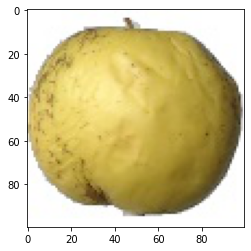

In [2]:
IMAGE_SIZE = [100, 100] # feel free to change depending on dataset

# training config:
epochs = 5
batch_size = 32

# https://www.kaggle.com/paultimothymooney/blood-cells
# train_path = '../large_files/blood_cell_images/TRAIN'
# valid_path = '../large_files/blood_cell_images/TEST'
#### The name of the validation folder is `Test`. Either change the file path here or the name of the folder
# https://www.kaggle.com/moltean/fruits
# train_path = '../large_files/fruits-360/Training'
# valid_path = '../large_files/fruits-360/Validation'
train_path = '../large_files/fruits-360-small/Training'
valid_path = '../large_files/fruits-360-small/Validation'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')


# look at an image for fun
plt.imshow(image.img_to_array(image.load_img(np.random.choice(image_files))).astype('uint8'))
plt.show()

In [3]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)


# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

In [4]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k



Found 490 images belonging to 3 classes.
{'Apple Golden 1': 0, 'Banana': 1, 'Strawberry': 2}


min: -86.939606 max: 151.061


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


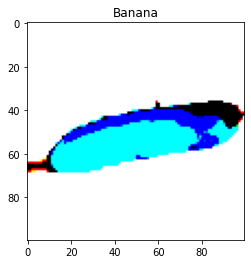

Found 1462 images belonging to 3 classes.
Found 490 images belonging to 3 classes.


In [5]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)


In [6]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)



Epoch 1/5
45/45 [==============================] - 34s 748ms/step - loss: 379216030.6689 - accuracy: 0.5140 - val_loss: 522771680.0000 - val_accuracy: 0.6604
Epoch 2/5
45/45 [==============================] - 36s 810ms/step - loss: 497052310.9171 - accuracy: 0.4622 - val_loss: 478787904.0000 - val_accuracy: 0.3231
Epoch 3/5
45/45 [==============================] - 60s 1s/step - loss: 457808985.2055 - accuracy: 0.5007 - val_loss: 286739936.0000 - val_accuracy: 0.3231
Epoch 4/5
45/45 [==============================] - 49s 1s/step - loss: 404399291.5556 - accuracy: 0.5000 - val_loss: 533907520.0000 - val_accuracy: 0.3384
Epoch 5/5
45/45 [==============================] - 50s 1s/step - loss: 434572975.7923 - accuracy: 0.5021 - val_loss: 455084672.0000 - val_accuracy: 0.7096


In [7]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


Generating confusion matrix 1462
Found 1462 images belonging to 3 classes.
[[  0 469  11]
 [  0 490   0]
 [  0  12 480]]
Generating confusion matrix 490
Found 490 images belonging to 3 classes.
[[  0 148  12]
 [  0 166   0]
 [  0   0 164]]


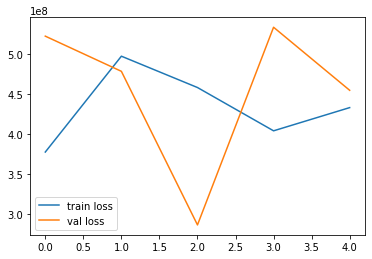

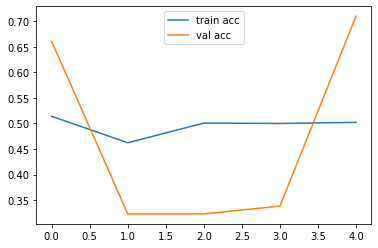

ModuleNotFoundError: No module named 'object_detection.util'

In [8]:
# plot some data

# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

from object_detection.util import plot_confusion_matrix
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')